In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------
# Parameters
# -------------------------------
img_height, img_width = 224, 224
batch_size = 32
max_epochs = 300  # Maximum epochs to train

# Adam optimizer parameters
learning_rate = 1e-4
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-7

# Early stopping: monitor validation loss with a patience of 15 epochs,
# and restore the best model weights
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# -------------------------------
# Paths & Filter Selection
# -------------------------------
# Preprocessed dataset path (images are already resized and augmented)
preprocessed_dataset_path = "/home/pranshu/project/data/Balanced_dataset_split_filter"

# Use only the K720_balance filter
filter_name = "K720_balance"

# Define class names (must match the folder names inside K590_balance)
classes = [
    "Papaya_healthy", "Papaya_diseased",
    "Potato_healthy", "Potato_diseased",
    "Tomato_healthy", "Tomato_diseased"
]

# Construct paths for train, validation, and test directories
filter_path = os.path.join(preprocessed_dataset_path, filter_name)
train_dir = os.path.join(filter_path, 'train')
validation_dir = os.path.join(filter_path, 'validation')
test_dir = os.path.join(filter_path, 'test')

# -------------------------------
# Data Generators
# -------------------------------
# Since images are preprocessed, we only need to rescale them.
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

2025-02-13 10:21:15.418691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 10:21:15.452522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 10:21:15.486362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 10:21:15.503466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 10:21:15.554704: I tensorflow/core/platform/cpu_feature_guar

Found 2121 images belonging to 6 classes.
Found 264 images belonging to 6 classes.
Found 267 images belonging to 6 classes.


In [2]:
# Build the Xception Model
# -------------------------------
# Load the pre-trained Xception model without its top layers.
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers to retain the ImageNet features.
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for classification.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(len(classes), activation='softmax')(x)

2025-02-13 10:21:20.146319: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Create the full model.
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the Adam optimizer configured as specified.
optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Optional: Display model architecture.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,873,774 (79.63 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [4]:
# Train the Model with Early Stopping
# -------------------------------
history = model.fit(
    train_generator,
    epochs=max_epochs,
    validation_data=validation_generator,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300


/home/pranshu/miniconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 589ms/step - accuracy: 0.2451 - loss: 1.7882 - val_accuracy: 0.4545 - val_loss: 1.5127
Epoch 2/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 514ms/step - accuracy: 0.3784 - loss: 1.5268 - val_accuracy: 0.5720 - val_loss: 1.3463
Epoch 3/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 34s 502ms/step - accuracy: 0.4530 - loss: 1.4088 - val_accuracy: 0.6098 - val_loss: 1.2270
Epoch 4/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 524ms/step - accuracy: 0.4836 - loss: 1.3091 - val_accuracy: 0.6402 - val_loss: 1.1356
Epoch 5/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 35s 510ms/step - accuracy: 0.5432 - loss: 1.2021 - val_accuracy: 0.6780 - val_loss: 1.0624
Epoch 6/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 34s 505ms/step - accuracy: 0.5652 - loss: 1.1486 - val_accuracy: 0.6742 - val_loss: 1.0033
Epoch 7/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 34s 500ms/step - accuracy: 0.5700 - loss: 1.0873 - val_accuracy: 0.6932 - val_loss: 0.9549
Epoch 8/300
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 537ms/step - accuracy: 0.6522 - loss: 0.9953 - val_accuracy

In [5]:
# -------------------------------
# Evaluate the Model on Test Set
# -------------------------------
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8082 - loss: 0.5011
Test Accuracy: 82.02%


In [6]:
# -------------------------------
# Compute Detailed Metrics on Test Set
# -------------------------------
# Get predictions on the test set.
test_preds = model.predict(test_generator)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_generator.classes

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step


In [7]:
# Generate classification report (includes precision, recall, f1-score)
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Classification Report:
                 precision    recall  f1-score   support

Papaya_diseased       0.73      0.73      0.73        30
 Papaya_healthy       0.80      0.78      0.79        36
Potato_diseased       0.83      0.87      0.85        63
 Potato_healthy       0.80      0.81      0.80        48
Tomato_diseased       0.85      0.87      0.86        45
 Tomato_healthy       0.88      0.80      0.84        45

       accuracy                           0.82       267
      macro avg       0.81      0.81      0.81       267
   weighted avg       0.82      0.82      0.82       267



In [8]:
# Compute confusion matrix.
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[22  6  1  1  0  0]
 [ 8 28  0  0  0  0]
 [ 0  0 55  8  0  0]
 [ 0  0  9 39  0  0]
 [ 0  0  0  1 39  5]
 [ 0  1  1  0  7 36]]


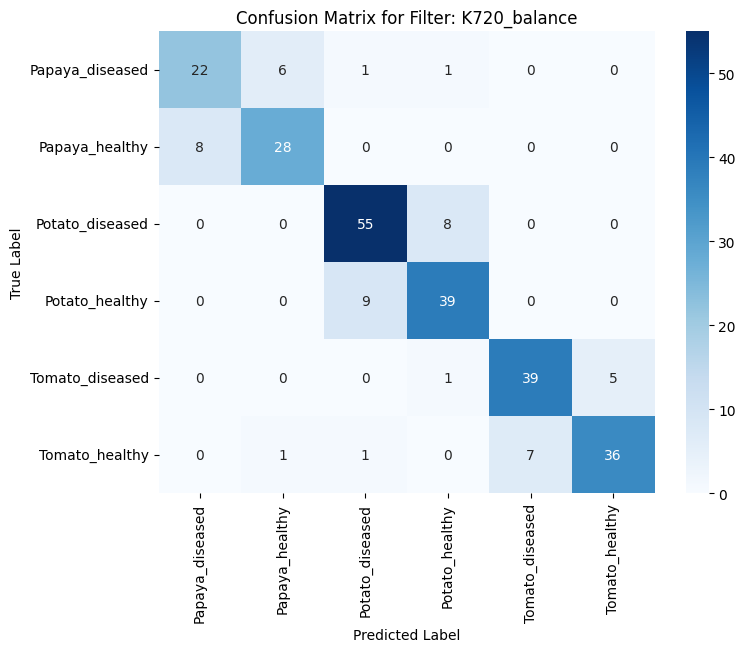

In [9]:
# -------------------------------
# Visualize the Confusion Matrix
# -------------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Filter: " + filter_name)
plt.show()

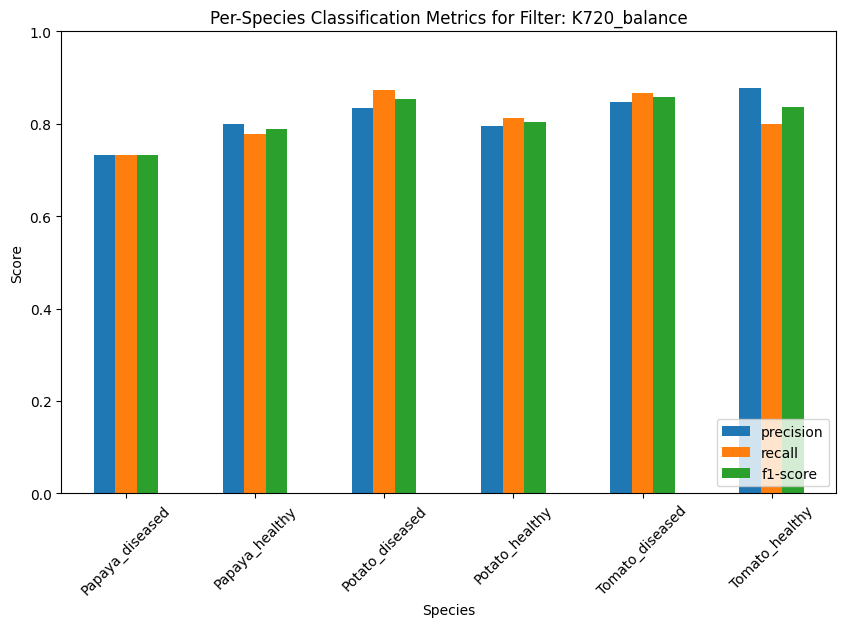

In [10]:
import pandas as pd
# -------------------------------
# Visualize Per-Species Metrics (Precision, Recall, F1-Score)
# -------------------------------
# Convert the classification report to a DataFrame for selected metrics.
report_df = pd.DataFrame(report).transpose()
metrics_df = report_df.loc[target_names, ['precision', 'recall', 'f1-score']]

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Per-Species Classification Metrics for Filter: " + filter_name)
plt.xlabel("Species")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


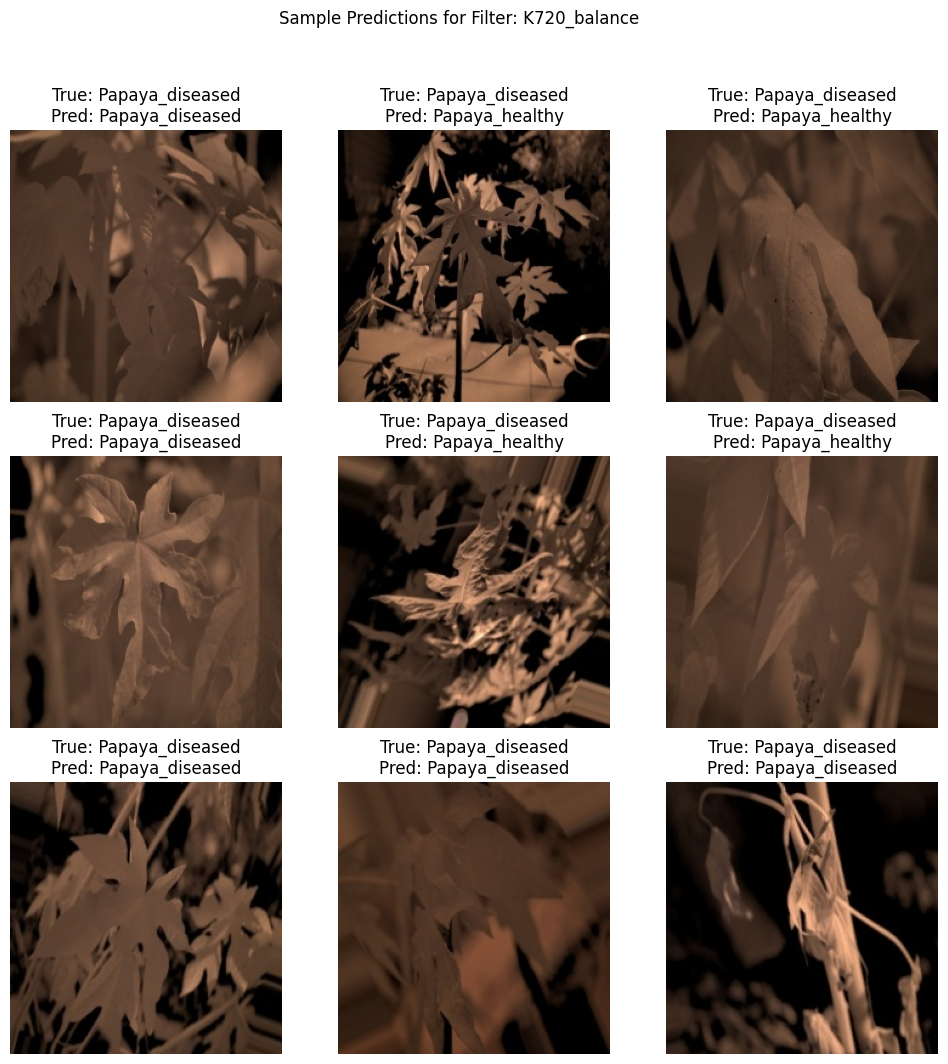

In [11]:
# -------------------------------
# Visualize Sample Test Images with Predictions
# -------------------------------
# Get a batch of test images.
test_images, test_labels = next(test_generator)
preds = model.predict(test_images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(test_labels, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}")
    plt.axis('off')
plt.suptitle("Sample Predictions for Filter: " + filter_name)
plt.show()

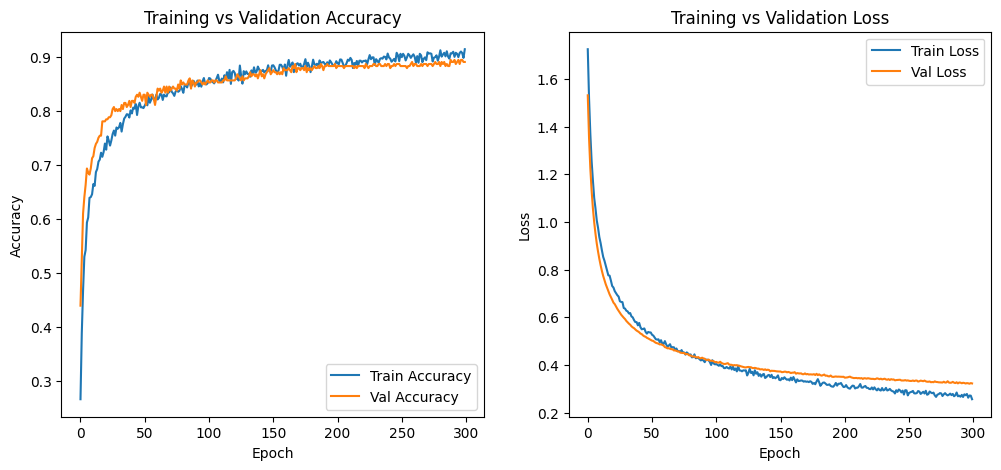

In [13]:
# -------------------------------
# Visualize Training History (Accuracy and Loss)
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()